# EECE 550 Homework 3
Shelby Quiring, 10157162, April 5th 2024

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import scipy as sci
import sympy as sp
import control as ctr
import control.matlab as ctrm

### Question 1: Buck Converter Sliding Mode Control

Duty Cycle: 12.3 %
Output Resistor: 0.53 Ohms
Capacitor: 11.719 uF
Inductor: 58.462 uH



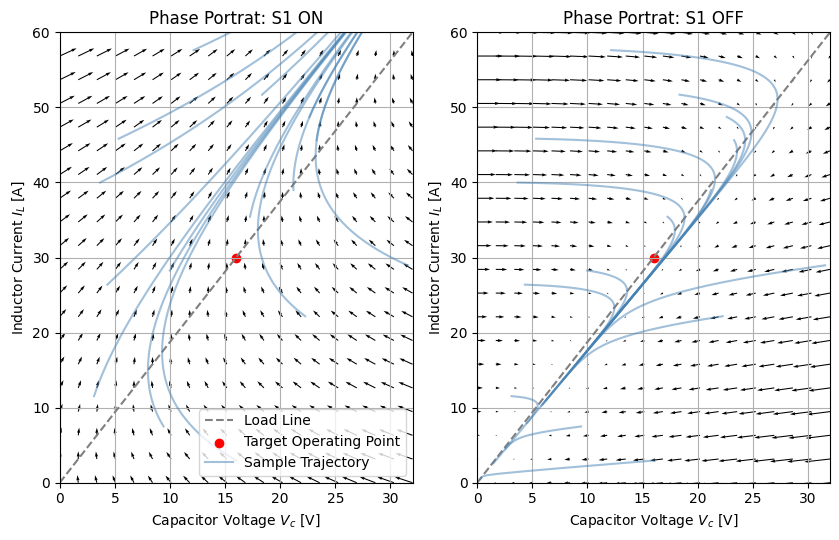

In [2]:
# Plot phase portraits of the on and off states to understand the existance of sliding conditions

# Input parameters
Vi = 130  # V
Vo = 16  # V
Io = 30  # A
delta_vo_pp_percent = 0.004  # Decimal percent
delta_il_pp_percent = 0.04  # Decimal percent
Fsw = 200e3  # Hz

# Calculated parameters
R = Vo/Io 
D = Vo/Vi

delta_il_pp = delta_il_pp_percent * Io
delta_vo_pp = delta_vo_pp_percent * Vo

C = 1 / (8*Fsw) * delta_il_pp / delta_vo_pp
L = (1-D) * Vo / (Fsw*delta_il_pp)

print(f'Duty Cycle: {D * 100:.1f} %')
print(f'Output Resistor: {R:.2f} Ohms')
print(f'Capacitor: {C * 1e6:.3f} uF')
print(f'Inductor: {L * 1e6:.3f} uH\n')

# State 1: S1 ON
gamma = np.array([
    [C, 0],
    [0, L]
])

alpha = np.array([
    [-1/R, 1],
    [-1,   0]
])

beta_on = np.array([
    [ 0 ],
    [ 1 ]
])

A_on = np.linalg.inv(gamma) @ alpha
B_on = np.linalg.inv(gamma) @ beta_on

# State 2: S1 OFF
beta_off = np.array([
    [ 0 ],
    [ 0 ]
])

A_off = np.linalg.inv(gamma) @ alpha
B_off = np.linalg.inv(gamma) @ beta_off


# Define input grid
window_percent = 1
num_points = 20
il_vec = np.linspace(*np.array([-1, 1])*Io*window_percent + Io, num_points)
vc_vec = np.linspace(*np.array([-1, 1])*Vo*window_percent + Vo, num_points)

Il, Vc = np.meshgrid(il_vec, vc_vec)

dIl_on = np.zeros_like(Il)
dVc_on = np.zeros_like(Vc)
dIl_off = np.zeros_like(Il)
dVc_off = np.zeros_like(Vc)

cond_1_on = np.zeros_like(Vc)
cond_1_off = np.zeros_like(Vc)
cond_1 = np.zeros_like(Vc)
cond_2 = np.zeros_like(Vc)

# Define target position vector
target = np.array([Vo, Io, 0]) 

# Calculate phase portraits for on and off cases
for idx, il_ in enumerate(il_vec):
    for jdx, vc_ in enumerate(vc_vec):
        # Calculate state and derivatives
        state = np.array([[vc_], [il_]])
        derivative_on = A_on @ state  +  B_on * Vi  #+  B1 * Vo
        derivative_off = A_on @ state  +  B_off * Vi  #+  B1 * Vo

        # Store outputs
        dVc_on[jdx, idx] = derivative_on[0][0]
        dIl_on[jdx, idx] = derivative_on[1][0]
        dVc_off[jdx, idx] = derivative_off[0][0]
        dIl_off[jdx, idx] = derivative_off[1][0]

        # # Calculate point-to-target vector
        # v_pt = target - np.array([*state.T[0], 0])
        # v_pt_hat = v_pt / np.linalg.norm(v_pt)
        # v_on = np.array([*derivative_on.T[0], 0])
        # v_off = np.array([*derivative_off.T[0], 0])

        # # Calculate condition 1: vectors point towards the target
        # # cond_1_on[jdx, idx] = np.dot(v_pt, v_on)
        # # cond_1_off[jdx, idx] = np.dot(v_pt, v_off)
        # # cond_1[jdx, idx] = np.dot(v_pt, v_on/np.linalg.norm(v_on) + v_off/np.linalg.norm(v_off))
        # cond_1[jdx, idx] = np.dot(v_pt, v_on/np.linalg.norm(v_on)) + np.dot(v_pt, v_off/np.linalg.norm(v_off))

        # # Calculate condition 2: normal components are opposed
        # cond_2[jdx, idx] = np.dot( np.cross(v_pt, v_on), np.cross(v_pt, v_off) )

# Calculate some trajectories for visualization
sys_on = ctr.ss(A_on, B_on, np.eye(2), 0)
sys_off = ctr.ss(A_off, B_off, np.eye(2), 0)
time = np.linspace(0, 0.0001, 1000)
u = Vi * np.ones_like(time)
num_traj = 15
on_trajectories = []
off_trajectories = []

for idx in range(num_traj):
    vc0 = np.random.uniform(np.min(vc_vec), np.max(vc_vec), 1)[0]
    il0 = np.random.uniform(np.min(il_vec), np.max(il_vec), 1)[0]
    init_conds = [vc0, il0]

    y_on, t_on, x_on = ctrm.lsim(sys_on, u, time, init_conds)
    y_off, t_off, x_off = ctrm.lsim(sys_off, u, time, init_conds)

    on_trajectories += [y_on]
    off_trajectories += [y_off]



# Controller slope
c = 0.275#1/10
slide = -c*(vc_vec - Vo) + Io

# Plot phase portraits
arrow_scale = None
ref_size = 15

fig, ax = plt.subplots(1, 2, figsize=(8.5, 5.5))
ax[0].quiver(Vc, Il, dVc_on, dIl_on, scale=arrow_scale)#, label='Derivative')#, cmap='cool')#, color='r')#, norm='normalize')
ax[0].plot(vc_vec, 1/R * vc_vec, '--', color='0.5', label='Load Line') # Load line
ax[0].scatter(Vo, Io, marker='o', color='r', label='Target Operating Point')
# ax[0].scatter(Vi, Vi/R, marker='o', color='g', label='S1 On Steady State')
# ax[0].scatter(0, 0, marker='o', color='b', label='S1 Off Steady State')

# ax[0].scatter(Vc[cond_1_on > 0], Il[cond_1_on > 0], s=ref_size, alpha = 0.5)
# ax[0].scatter(Vc[cond_1_off > 0], Il[cond_1_off > 0], s=ref_size, alpha = 0.5)
# ax[0].scatter(Vc[cond_1 > 0], Il[cond_1 > 0], s=ref_size, c=cond_1[cond_1 > 0], cmap='cool', alpha=0.5)
[ax[0].plot(*on_trajectories[idx].T, color='steelblue', alpha=0.5, label='Sample Trajectory'*(idx==0)) for idx in range(num_traj)]

ax[0].grid('enable')
ax[0].legend()
ax[0].set_xlabel('Capacitor Voltage $V_c$ [V]')
ax[0].set_ylabel('Inductor Current $I_L$ [A]')
ax[0].set_title('Phase Portrat: S1 ON')
ax[0].set_xlim([np.min(vc_vec), np.max(vc_vec)])
ax[0].set_ylim([np.min(il_vec), np.max(il_vec)])


ax[1].quiver(Vc, Il, dVc_off, dIl_off, scale=arrow_scale)#, cmap='cool')#color='b')
ax[1].plot(vc_vec, 1/R * vc_vec, '--', color='0.5') # Load line
ax[1].scatter(Vo, Io, marker='o', color='r', label='Target Operating Point')
# ax[1].scatter(Vi, Vi/R, marker='o', color='g', label='S1 On Steady State')
# ax[1].scatter(0, 0, marker='o', color='b', label='S1 Off Steady State')
# ax[1].scatter(Vc[cond_2 < 0], Il[cond_2 < 0], s=ref_size, c=cond_2[cond_2 < 0], cmap='cool', alpha=0.5)
[ax[1].plot(*off_trajectories[idx].T, color='steelblue', alpha=0.5) for idx in range(num_traj)]


ax[1].grid('enable')
ax[1].set_xlabel('Capacitor Voltage $V_c$ [V]')
ax[1].set_ylabel('Inductor Current $I_L$ [A]')
ax[1].set_title('Phase Portrat: S1 OFF')
ax[1].set_xlim([np.min(vc_vec), np.max(vc_vec)])
ax[1].set_ylim([np.min(il_vec), np.max(il_vec)])


fig.tight_layout()
# fig.savefig('figs/buck_phase_portrait.png')

Text(0.5, 0.98, 'Buck Converter Turn-On Transient w/ Sliding Mode Control')

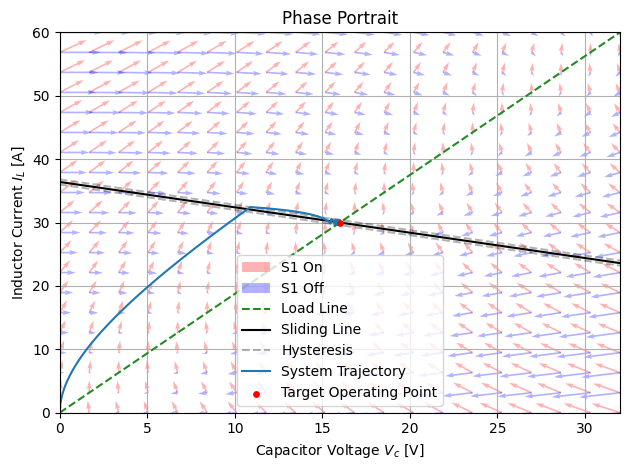

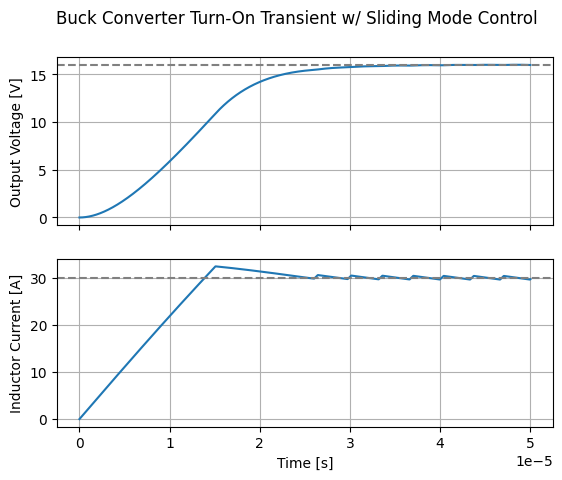

In [3]:
# Define the system dynamics with sliding mode control
prev_s1 = 0
def sliding_control_sys(t, state_1d, inputs):
    global prev_s1
    state = np.reshape(state_1d, (2, 1))

    # Unpack inputs
    sys, Vi, c, target, hys = inputs.values()
    
    # Calculate switch state
    C = np.array([[c], [1]])
    s1 = C.T @ (state - (target - hys + 2*hys*prev_s1)) < 0
    
    # Calculate state derivative
    state_derivative = sys.A @ state  +  sys.B * Vi * s1 
    prev_s1 = s1
    
    return state_derivative.T[0]

# Calculate a trajectory for visualization
Tmax = 0.00005
dt = 1e-8
time = np.arange(0, Tmax, dt)
target = np.array([[Vo], [Io]])
reltol = 1e-5
solver = 'LSODA'
hys = 1 * np.array([[1],[0]])
c = 0.4

init_conds = [0, 0]
sim_inputs = {
    'sys': sys_on,
    'Vin': Vi,
    'c': c,
    'target': target, 
    'hysteresis': hys
}
sol = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs,), y0=init_conds, rtol=reltol, method=solver)


# Plot phase portraits
arrow_scale = None
ref_size = 15

slide = -c*(vc_vec - Vo) + Io
slide_upper = -c*(vc_vec - Vo - hys[0][0]) + Io + hys[1][0]
slide_lower = -c*(vc_vec - Vo + hys[0][0]) + Io - hys[1][0]

fig, ax = plt.subplots()

ax.quiver(Vc, Il, dVc_on, dIl_on, scale=arrow_scale, color='r', alpha=0.3, label='S1 On')
ax.quiver(Vc, Il, dVc_off, dIl_off, scale=arrow_scale, color='b', alpha=0.3, label='S1 Off')
ax.plot(vc_vec, 1/R * vc_vec, '--', color='forestgreen', label='Load Line') # Load line
ax.plot(vc_vec, slide, 'k', label='Sliding Line') # Controller line
ax.plot(vc_vec, slide_upper, 'k', linestyle='--', alpha=0.3, label='Hysteresis') # Controller line
ax.plot(vc_vec, slide_lower, 'k', linestyle='--', alpha=0.3) # Controller line

ax.plot(sol.y[0], sol.y[1], label='System Trajectory')
ax.scatter(Vo, Io, s=15, marker='o', color='r', label='Target Operating Point', zorder=100)

ax.grid('enable')
ax.set_xlabel('Capacitor Voltage $V_c$ [V]')
ax.set_ylabel('Inductor Current $I_L$ [A]')
ax.set_title('Phase Portrait')

# ax.set_xlim(np.array([0.9, 1.1])*Vo)
# ax.set_ylim(np.array([0.9, 1.1])*Io)
# fig.savefig('figs/buck_turnon_closeup.png')

ax.set_xlim([np.min(vc_vec), np.max(vc_vec)])
ax.set_ylim([np.min(il_vec), np.max(il_vec)])
ax.legend()
# fig.savefig('figs/buck_turnon.png')

fig.tight_layout()


fig, ax = plt.subplots(2, 1, sharex=True)
p = 0
ax[p].plot(sol.t, sol.y[0])
ax[p].axhline(Vo, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Output Voltage [V]')

p += 1
ax[p].plot(sol.t, sol.y[1])
ax[p].axhline(Io, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Inductor Current [A]')
ax[p].set_xlabel('Time [s]')

fig.suptitle('Buck Converter Turn-On Transient w/ Sliding Mode Control')
# fig.savefig('figs/buck_turnon_time.eps', format='eps')

Text(0.5, 0.98, 'Buck Converter Load Step Transients w/ Sliding Mode Control')

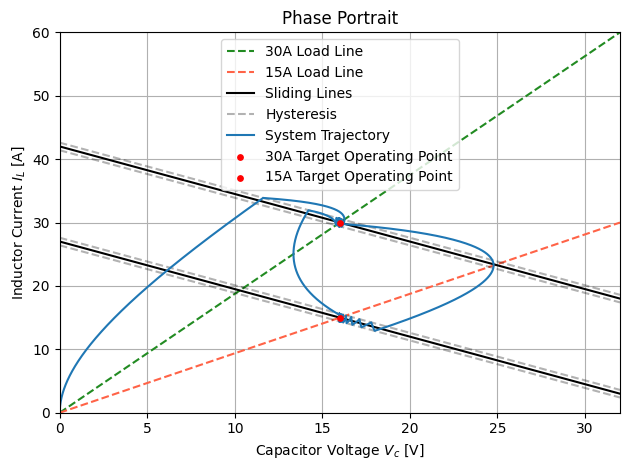

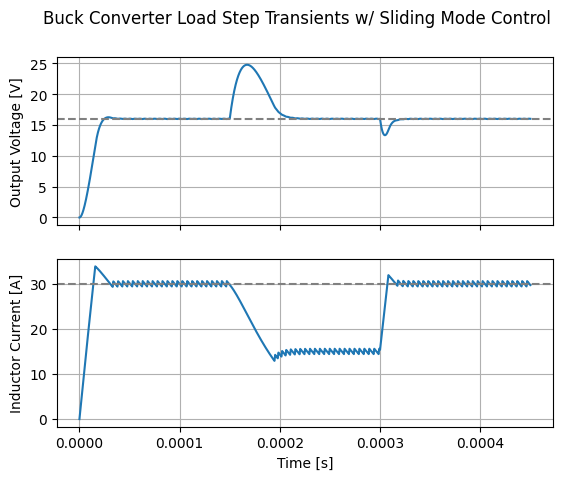

In [4]:
# Current steps
# Create new state space systems for each load condition
alpha_15 = np.array([
    [-1/(2*R), 1],
    [-1,   0]
])

A_15 = np.linalg.inv(gamma) @ alpha_15

sys_30A = sys_on
sys_15A = ctr.ss(A_15, B_on, np.eye(2), 0)

# Simulate startup
# Simulation parameters
Tmax = 0.00015
dt = 1e-8
time_segment = np.arange(0, Tmax, dt)
reltol = 1e-5
solver = 'LSODA'
hys = np.array([[0],[1]]) * delta_il_pp/2

c = 0.75 # Sliding line

# Simulate turn-on
target = np.array([[Vo], [Io]])
init_conds = [0, 0]
sim_inputs_30A = {
    'sys': sys_30A,
    'Vin': Vi,
    'c': c,
    'target': target, 
    'hysteresis': hys
}
sol_1 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_30A,), y0=init_conds, rtol=reltol, method=solver)
vc_1, il_1 = sol_1.y

# Simulate current step down
target = np.array([[Vo], [Io/2]])
init_conds = [vc_1[-1], il_1[-1]]
sim_inputs_15A = {
    'sys': sys_15A,
    'Vin': Vi,
    'c': c,
    'target': target, 
    'hysteresis': hys
}
sol_2 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_15A,), y0=init_conds, rtol=reltol, method=solver)
vc_2, il_2 = sol_2.y

# Simulate current step up
target = np.array([[Vo], [Io]])
init_conds = [vc_2[-1], il_2[-1]]
sol_3 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_30A,), y0=init_conds, rtol=reltol, method=solver)
vc_3, il_3 = sol_3.y


# Plot everything
time_all = np.block([sol_1.t, Tmax + sol_2.t, Tmax*2 + sol_3.t])
vc_all = [*vc_1, *vc_2, *vc_3]
il_all = [*il_1, *il_2, *il_3]


# Phase plane plot
fig, ax = plt.subplots()

arrow_scale = None#1/(L*C) / 20
ref_size = 15

slide_1 = -c*(vc_vec - Vo) + Io
slide_upper_1 = -c*(vc_vec - Vo - hys[0][0]) + Io + hys[1][0]
slide_lower_1 = -c*(vc_vec - Vo + hys[0][0]) + Io - hys[1][0]

slide_2 = -c*(vc_vec - Vo) + Io/2
slide_upper_2 = -c*(vc_vec - Vo - hys[0][0]) + Io/2 + hys[1][0]
slide_lower_2 = -c*(vc_vec - Vo + hys[0][0]) + Io/2 - hys[1][0]

# ax.quiver(Vc, Il, dVc_on, dIl_on, scale=arrow_scale, color='r', alpha=0.3, label='S1 On')
# ax.quiver(Vc, Il, dVc_off, dIl_off, scale=arrow_scale, color='b', alpha=0.3, label='S1 Off')

ax.plot(vc_vec, 1/R * vc_vec, '--', color='forestgreen', label='30A Load Line') # Load line
ax.plot(vc_vec, 1/(2*R) * vc_vec, '--', color='tomato', label='15A Load Line') # Load line


ax.plot(vc_vec, slide_1, 'k', label='Sliding Lines') # Controller line
ax.plot(vc_vec, slide_upper_1, 'k', linestyle='--', alpha=0.3, label='Hysteresis') # Controller line
ax.plot(vc_vec, slide_lower_1, 'k', linestyle='--', alpha=0.3) # Controller line

ax.plot(vc_vec, slide_2, 'k') # Controller line
ax.plot(vc_vec, slide_upper_2, 'k', linestyle='--', alpha=0.3) # Controller line
ax.plot(vc_vec, slide_lower_2, 'k', linestyle='--', alpha=0.3) # Controller line

ax.plot(vc_all, il_all, label='System Trajectory')
ax.scatter(Vo, Io, s=15, marker='o', color='r', label='30A Target Operating Point', zorder=100)
ax.scatter(Vo, Io/2, s=15, marker='o', color='r', label='15A Target Operating Point', zorder=100)

ax.grid('enable')
ax.legend()
ax.set_xlabel('Capacitor Voltage $V_c$ [V]')
ax.set_ylabel('Inductor Current $I_L$ [A]')
ax.set_title('Phase Portrait')

ax.set_xlim([np.min(vc_vec), np.max(vc_vec)])
ax.set_ylim([np.min(il_vec), np.max(il_vec)])

fig.tight_layout()
# fig.savefig('figs/buck_currentsteps_phase.png')


# Time domain plot
fig, ax = plt.subplots(2, 1, sharex=True)
p = 0
ax[p].plot(time_all, vc_all)
ax[p].axhline(Vo, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Output Voltage [V]')

p += 1
ax[p].plot(time_all, il_all)
ax[p].axhline(Io, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Inductor Current [A]')
ax[p].set_xlabel('Time [s]')

fig.suptitle('Buck Converter Load Step Transients w/ Sliding Mode Control')
# fig.savefig('figs/buck_currentsteps_time.png')

### Question 2: Boost Converter Sliding Mode Control

Duty Cycle: 73.1 %
Output Resistor: 5.20 Ohms
Capacitor: 73.964 uF
Inductor: 72.485 uH



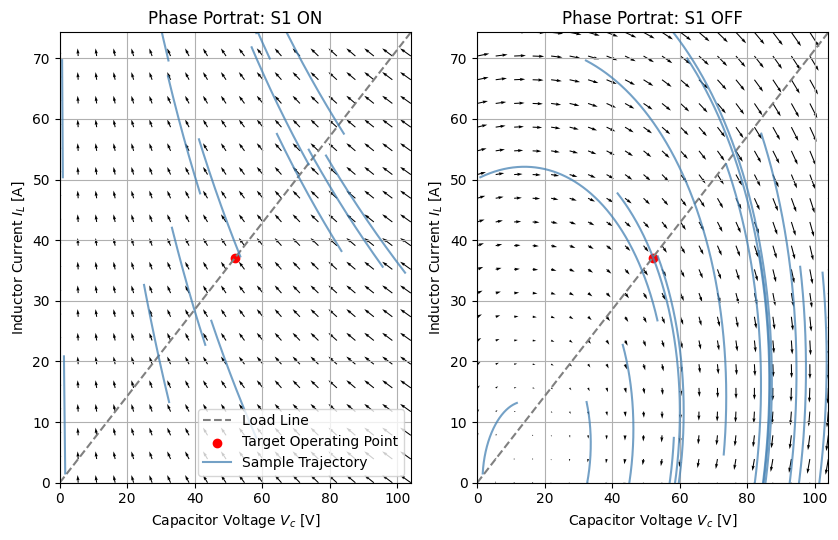

In [5]:
# Plot phase portraits of the on and off states to understand the existance of sliding conditions

# Input parameters
Vi = 14  # V
Vo = 52  # V
Io = 10  # A
delta_vo_pp_percent = 0.02  # Decimal percent
delta_il_pp_percent = 0.04  # Decimal percent
Fsw = 95e3  # Hz

# Calculated parameters
R = Vo/Io 
D = (Vo - Vi) / Vo

delta_il_pp = delta_il_pp_percent * Io / (1-D)
delta_vo_pp = delta_vo_pp_percent * Vo

C = Vo * D / (Fsw * R * delta_vo_pp)
L = Vi * D / (Fsw * delta_il_pp)

print(f'Duty Cycle: {D * 100:.1f} %')
print(f'Output Resistor: {R:.2f} Ohms')
print(f'Capacitor: {C * 1e6:.3f} uF')
print(f'Inductor: {L * 1e6:.3f} uH\n')

# State 1: S1 ON
gamma = np.array([
    [C, 0],
    [0, L]
])

alpha_on = np.array([
    [-1/R, 0],
    [0,   0]
])

alpha_off = np.array([
    [-1/R, 1],
    [-1,   0]
])

beta = np.array([
    [ 0 ],
    [ 1 ]
])

A_on = np.linalg.inv(gamma) @ alpha_on
B_on = np.linalg.inv(gamma) @ beta

# State 2: S1 OFF
beta_off = np.array([
    [ 0 ],
    [ 0 ]
])

A_off = np.linalg.inv(gamma) @ alpha_off
B_off = np.linalg.inv(gamma) @ beta


# Define input grid
il_nom = Vo / R * (Vo / Vi)
vc_lim = Vi
window_percent = 1
num_points = 20
il_vec = np.linspace(*np.array([-1, 1])*il_nom*window_percent + il_nom, num_points)
vc_vec = np.linspace(*np.array([-1, 1])*Vo*window_percent + Vo, num_points)

Il, Vc = np.meshgrid(il_vec, vc_vec)

dIl_on = np.zeros_like(Il)
dVc_on = np.zeros_like(Vc)
dIl_off = np.zeros_like(Il)
dVc_off = np.zeros_like(Vc)

cond_1_on = np.zeros_like(Vc)
cond_1_off = np.zeros_like(Vc)
cond_1 = np.zeros_like(Vc)
cond_2 = np.zeros_like(Vc)

# Define target position vector
target = np.array([Vo, Io, 0]) 

# Calculate phase portraits for on and off cases
for idx, il_ in enumerate(il_vec):
    for jdx, vc_ in enumerate(vc_vec):
        # Calculate state and derivatives
        state = np.array([[vc_], [il_]])
        derivative_on = A_on @ state  +  B_on * Vi 
        derivative_off = A_off @ state  +  B_off * Vi  

        # Store outputs
        dVc_on[jdx, idx] = derivative_on[0][0]
        dIl_on[jdx, idx] = derivative_on[1][0]
        dVc_off[jdx, idx] = derivative_off[0][0]
        dIl_off[jdx, idx] = derivative_off[1][0]

        # # Calculate point-to-target vector
        # v_pt = target - np.array([*state.T[0], 0])
        # v_pt_hat = v_pt / np.linalg.norm(v_pt)
        # v_on = np.array([*derivative_on.T[0], 0])
        # v_off = np.array([*derivative_off.T[0], 0])

        # # Calculate condition 1: vectors point towards the target
        # # cond_1_on[jdx, idx] = np.dot(v_pt, v_on)
        # # cond_1_off[jdx, idx] = np.dot(v_pt, v_off)
        # # cond_1[jdx, idx] = np.dot(v_pt, v_on/np.linalg.norm(v_on) + v_off/np.linalg.norm(v_off))
        # cond_1[jdx, idx] = np.dot(v_pt, v_on/np.linalg.norm(v_on)) + np.dot(v_pt, v_off/np.linalg.norm(v_off))

        # # Calculate condition 2: normal components are opposed
        # cond_2[jdx, idx] = np.dot( np.cross(v_pt, v_on), np.cross(v_pt, v_off) )

# Calculate some trajectories for visualization
sys_on = ctr.ss(A_on, B_on, np.eye(2), 0)
sys_off = ctr.ss(A_off, B_off, np.eye(2), 0)
time = np.linspace(0, 0.0001, 1000)
u = Vi * np.ones_like(time)
num_traj = 15
on_trajectories = []
off_trajectories = []

for idx in range(num_traj):
    vc0 = np.random.uniform(np.min(vc_vec), np.max(vc_vec), 1)[0]
    il0 = np.random.uniform(np.min(il_vec), np.max(il_vec), 1)[0]
    init_conds = [vc0, il0]

    y_on, t_on, x_on = ctrm.lsim(sys_on, u, time, init_conds)
    y_off, t_off, x_off = ctrm.lsim(sys_off, u, time, init_conds)

    on_trajectories += [y_on]
    off_trajectories += [y_off]


Ic = Il 
M_on = np.hypot(dVc_on, dIl_on)
M_off = np.hypot(dVc_off, dIl_off)

# Controller slope
c = 1/10
slide = -c*(vc_vec - Vo) + Io

# Plot phase portraits
arrow_scale = None
ref_size = 15

fig, ax = plt.subplots(1, 2, figsize=(8.5, 5.5))
ax[0].quiver(Vc, Il, dVc_on, dIl_on, scale=arrow_scale)#, label='Derivative')#, cmap='cool')#, color='r')#, norm='normalize')
ax[0].plot(vc_vec, 1/R * vc_vec * 1/(1-D), '--', color='0.5', label='Load Line') # Load line
ax[0].scatter(Vo, Io / (1-D), marker='o', color='r', label='Target Operating Point')
# ax[0].scatter(Vi, Vi/R, marker='o', color='g', label='S1 On Steady State')
# ax[0].scatter(0, 0, marker='o', color='b', label='S1 Off Steady State')

# ax[0].scatter(Vc[cond_1_on > 0], Il[cond_1_on > 0], s=ref_size, alpha = 0.5)
# ax[0].scatter(Vc[cond_1_off > 0], Il[cond_1_off > 0], s=ref_size, alpha = 0.5)
# ax[0].scatter(Vc[cond_1 > 0], Il[cond_1 > 0], s=ref_size, c=cond_1[cond_1 > 0], cmap='cool', alpha=0.5)
[ax[0].plot(*on_trajectories[idx].T, color='steelblue', alpha=0.75, label='Sample Trajectory'*(idx==0)) for idx in range(num_traj)]

ax[0].grid('enable')
ax[0].legend()
ax[0].set_xlabel('Capacitor Voltage $V_c$ [V]')
ax[0].set_ylabel('Inductor Current $I_L$ [A]')
ax[0].set_title('Phase Portrat: S1 ON')
ax[0].set_xlim([np.min(vc_vec), np.max(vc_vec)])
ax[0].set_ylim([np.min(il_vec), np.max(il_vec)])



ax[1].quiver(Vc, Il, dVc_off, dIl_off, scale=arrow_scale)#, cmap='cool')#color='b')
ax[1].plot(vc_vec, 1/R * vc_vec * 1/(1-D), '--', color='0.5') # Load line
ax[1].scatter(Vo, Io / (1-D), marker='o', color='r', label='Target Operating Point')
# ax[1].scatter(Vi, Vi/R, marker='o', color='g', label='S1 On Steady State')
# ax[1].scatter(0, 0, marker='o', color='b', label='S1 Off Steady State')
# ax[1].scatter(Vc[cond_2 < 0], Il[cond_2 < 0], s=ref_size, c=cond_2[cond_2 < 0], cmap='cool', alpha=0.5)
[ax[1].plot(*off_trajectories[idx].T, color='steelblue', alpha=0.75) for idx in range(num_traj)]

ax[1].grid('enable')
ax[1].set_xlabel('Capacitor Voltage $V_c$ [V]')
ax[1].set_ylabel('Inductor Current $I_L$ [A]')
ax[1].set_title('Phase Portrat: S1 OFF')

ax[1].set_xlim([np.min(vc_vec), np.max(vc_vec)])
ax[1].set_ylim([np.min(il_vec), np.max(il_vec)])


fig.tight_layout()
# fig.savefig('figs/boost_phase_portrait.png')

Text(0.5, 0.98, 'Boost Converter Turn-On Transient w/ Sliding Mode Control')

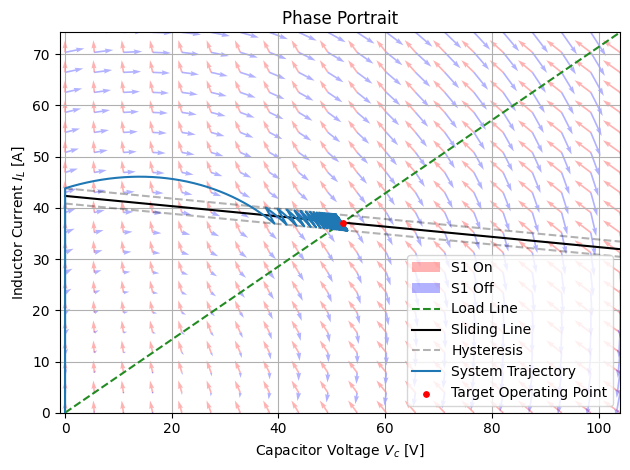

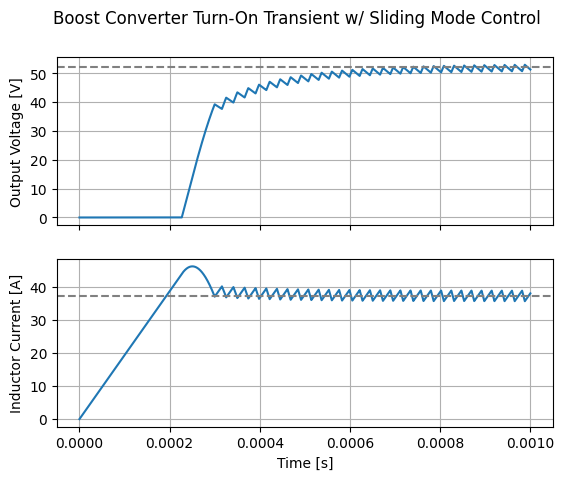

In [6]:
# Define the system dynamics with sliding mode control
prev_s1 = 0
def sliding_control_sys(t, state_1d, inputs):
    global prev_s1
    state = np.reshape(state_1d, (2, 1))

    # Unpack inputs
    sys_on, sys_off, Vi, c, target, hys = inputs.values()
    
    # Calculate switch state
    C = np.array([[c], [1]])
    s1 = (C.T @ (state - (target - hys + 2*hys*prev_s1)) < 0)[0][0]
    
    # Calculate state derivative
    A = sys_on.A*s1 + sys_off.A*(1-s1)
    B = sys_on.B*s1 + sys_off.B*(1-s1)

    state_derivative = A @ state  +  B * Vi 
    prev_s1 = s1
    
    return state_derivative.T[0]

# Calculate a trajectory for visualization
Tmax = 0.001
dt = 1e-7
time = np.arange(0, Tmax, dt)
target = np.array([[Vo], [il_nom]])
reltol = 1e-5
solver = 'LSODA'
hys = np.array([[0],[1]]) * delta_il_pp
c = 0.1

init_conds = [0, 0]
sim_inputs = {
    'sys_on': sys_on,
    'sys_off': sys_off,
    'Vin': Vi,
    'c': c,
    'target': target, 
    'hysteresis': hys
}
sol = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs,), y0=init_conds, rtol=reltol, method=solver)


# Plot phase portraits
arrow_scale = None#1/(L*C) / 20
ref_size = 15

slide = -c*(vc_vec - Vo) + il_nom
slide_upper = -c*(vc_vec - Vo - hys[0][0]) + il_nom + hys[1][0]
slide_lower = -c*(vc_vec - Vo + hys[0][0]) + il_nom - hys[1][0]

fig, ax = plt.subplots()

ax.quiver(Vc, Il, dVc_on, dIl_on, scale=arrow_scale, color='r', alpha=0.3, label='S1 On')
ax.quiver(Vc, Il, dVc_off, dIl_off, scale=arrow_scale, color='b', alpha=0.3, label='S1 Off')
ax.plot(vc_vec, 1/R * vc_vec / (1-D), '--', color='forestgreen', label='Load Line') # Load line
ax.plot(vc_vec, slide, 'k', label='Sliding Line') # Controller line
ax.plot(vc_vec, slide_upper, 'k', linestyle='--', alpha=0.3, label='Hysteresis') # Controller line
ax.plot(vc_vec, slide_lower, 'k', linestyle='--', alpha=0.3) # Controller line

ax.plot(sol.y[0], sol.y[1], label='System Trajectory')
ax.scatter(Vo, il_nom, s=15, marker='o', color='r', label='Target Operating Point', zorder=100)


ax.grid('enable')
ax.set_xlabel('Capacitor Voltage $V_c$ [V]')
ax.set_ylabel('Inductor Current $I_L$ [A]')
ax.set_title('Phase Portrait')

# ax.set_xlim(np.array([0.7, 1.2])*Vo)
# ax.set_ylim(np.array([0.9, 1.1])*Io / (1-D))
# fig.savefig('figs/boost_turnon_closeup.png')

ax.set_xlim([np.min(vc_vec) - 1, np.max(vc_vec)])
ax.set_ylim([np.min(il_vec), np.max(il_vec)])
ax.legend()
# fig.savefig('figs/boost_turnon.png')

fig.tight_layout()

fig, ax = plt.subplots(2, 1, sharex=True)
p = 0
ax[p].plot(sol.t, sol.y[0])
ax[p].axhline(Vo, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Output Voltage [V]')

p += 1
ax[p].plot(sol.t, sol.y[1])
ax[p].axhline(il_nom, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Inductor Current [A]')
ax[p].set_xlabel('Time [s]')

fig.suptitle('Boost Converter Turn-On Transient w/ Sliding Mode Control')
# fig.savefig('figs/boost_turnon_time.eps', format='eps')


Text(0.5, 0.98, 'Boost Converter Load Step Transients w/ Sliding Mode Control')

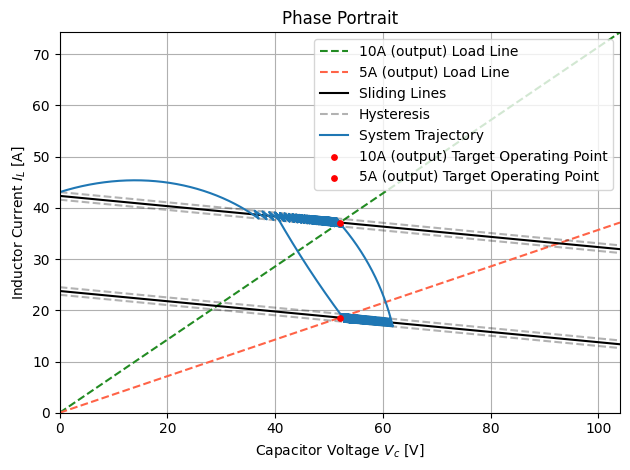

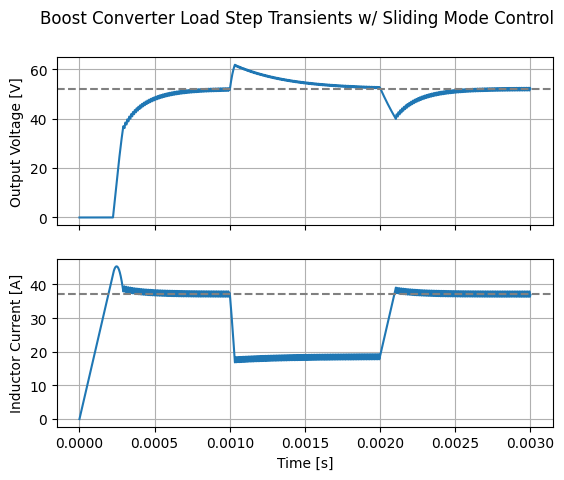

In [7]:
# Current steps
# Create new state space systems for each load condition
alpha_15_on = np.array([
    [-1/(2*R), 0],
    [0,   0]
])

alpha_15_off = np.array([
    [-1/(2*R), 1],
    [-1,   0]
])

A_15_on = np.linalg.inv(gamma) @ alpha_15_on
A_15_off = np.linalg.inv(gamma) @ alpha_15_off

sys_30A_on = sys_on
sys_30A_off = sys_off
sys_15A_on = ctr.ss(A_15_on, B_on, np.eye(2), 0)
sys_15A_off = ctr.ss(A_15_off, B_off, np.eye(2), 0)

# Simulate startup
# Simulation parameters
Tmax = 0.001
dt = 5e-8
time_segment = np.arange(0, Tmax, dt)
reltol = 1e-6
solver = 'LSODA'
hys = np.array([[0],[1]]) * delta_il_pp/2

c = 1/10 # Sliding line

# Simulate turn-on
target = np.array([[Vo], [il_nom]])
init_conds = [0, 0]
sim_inputs_30A = {
    'sys_on': sys_30A_on,
    'sys_off': sys_30A_off,
    'Vin': Vi,
    'c': c,
    'target': target, 
    'hysteresis': hys
}
sol_1 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_30A,), y0=init_conds, rtol=reltol, method=solver)
vc_1, il_1 = sol_1.y

# Simulate current step down
target = np.array([[Vo], [il_nom/2]])
init_conds = [vc_1[-1], il_1[-1]]
sim_inputs_15A = {
    'sys_on': sys_15A_on,
    'sys_off': sys_15A_off,
    'Vin': Vi,
    'c': c,
    'target': target, 
    'hysteresis': hys
}
sol_2 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_15A,), y0=init_conds, rtol=reltol, method=solver)
vc_2, il_2 = sol_2.y

# Simulate current step up
target = np.array([[Vo], [il_nom]])
init_conds = [vc_2[-1], il_2[-1]]
sol_3 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_30A,), y0=init_conds, rtol=reltol, method=solver)
vc_3, il_3 = sol_3.y


# Plot everything
time_all = np.block([sol_1.t, Tmax + sol_2.t, Tmax*2 + sol_3.t])
vc_all = [*vc_1, *vc_2, *vc_3]
il_all = [*il_1, *il_2, *il_3]


# Phase plane plot
fig, ax = plt.subplots()

arrow_scale = None#1/(L*C) / 20
ref_size = 15

slide_1 = -c*(vc_vec - Vo) + il_nom
slide_upper_1 = -c*(vc_vec - Vo - hys[0][0]) + il_nom + hys[1][0]
slide_lower_1 = -c*(vc_vec - Vo + hys[0][0]) + il_nom - hys[1][0]

slide_2 = -c*(vc_vec - Vo) + il_nom/2
slide_upper_2 = -c*(vc_vec - Vo - hys[0][0]) + il_nom/2 + hys[1][0]
slide_lower_2 = -c*(vc_vec - Vo + hys[0][0]) + il_nom/2 - hys[1][0]

# ax.quiver(Vc, Il, dVc_on, dIl_on, scale=arrow_scale, color='r', alpha=0.3, label='S1 On')
# ax.quiver(Vc, Il, dVc_off, dIl_off, scale=arrow_scale, color='b', alpha=0.3, label='S1 Off')

ax.plot(vc_vec, 1/R * vc_vec / (1-D), '--', color='forestgreen', label='10A (output) Load Line') # Load line
ax.plot(vc_vec, 1/(2*R) * vc_vec / (1-D), '--', color='tomato', label='5A (output) Load Line') # Load line


ax.plot(vc_vec, slide_1, 'k', label='Sliding Lines') # Controller line
ax.plot(vc_vec, slide_upper_1, 'k', linestyle='--', alpha=0.3, label='Hysteresis') # Controller line
ax.plot(vc_vec, slide_lower_1, 'k', linestyle='--', alpha=0.3) # Controller line

ax.plot(vc_vec, slide_2, 'k') # Controller line
ax.plot(vc_vec, slide_upper_2, 'k', linestyle='--', alpha=0.3) # Controller line
ax.plot(vc_vec, slide_lower_2, 'k', linestyle='--', alpha=0.3) # Controller line

ax.plot(vc_all, il_all, label='System Trajectory')
ax.scatter(Vo, Io / (1-D), s=15, marker='o', color='r', label='10A (output) Target Operating Point', zorder=100)
ax.scatter(Vo, Io/2 / (1-D), s=15, marker='o', color='r', label='5A (output) Target Operating Point', zorder=100)

ax.grid('enable')
ax.legend()
ax.set_xlabel('Capacitor Voltage $V_c$ [V]')
ax.set_ylabel('Inductor Current $I_L$ [A]')
ax.set_title('Phase Portrait')

ax.set_xlim([np.min(vc_vec), np.max(vc_vec)])
ax.set_ylim([np.min(il_vec), np.max(il_vec)])


fig.tight_layout()
# fig.savefig('figs/boost_currentsteps_phase.png')



# Time domain plot
fig, ax = plt.subplots(2, 1, sharex=True)
p = 0
ax[p].plot(time_all, vc_all)
ax[p].axhline(Vo, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Output Voltage [V]')

p += 1
ax[p].plot(time_all, il_all)
ax[p].axhline(Io/(1-D), linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Inductor Current [A]')
ax[p].set_xlabel('Time [s]')

fig.suptitle('Boost Converter Load Step Transients w/ Sliding Mode Control')
# fig.savefig('figs/boost_currentsteps_time.png')


4 states have been removed from the model


Text(0.5, 0.98, 'Boost Converter Load Step Transients\n Sliding Mode vs Small Signal Control')

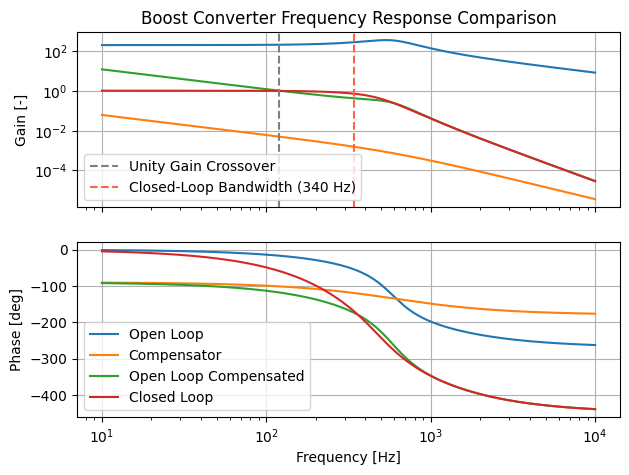

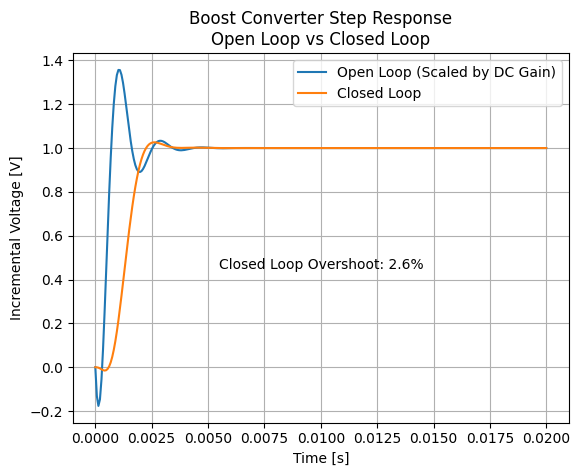

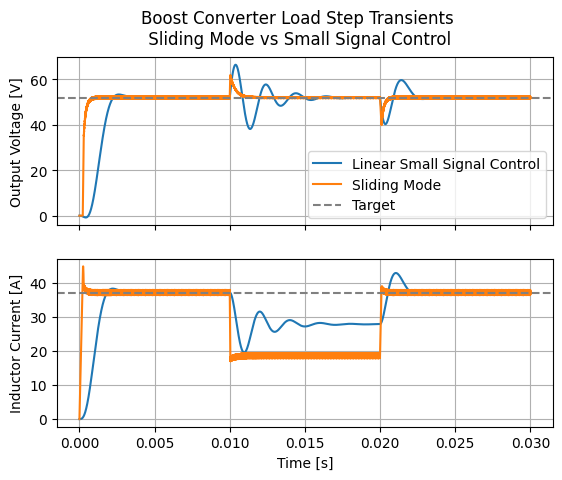

In [8]:
# Define matricies
gamma_ss = np.diag([L, C])

alpha_ss = np.array([
    [ 0,     -(1-D) ],
    [ 1-D,   -1/R   ]
])

# Only duty cycle input
beta_ss = np.array([
    [ Vo ],
    [-Io/(1-D) ]
])

A_ss = np.linalg.inv(gamma_ss) @ alpha_ss
B_ss = np.linalg.inv(gamma_ss) @ beta_ss
C_ss = np.array([0, 1])
D_ss = np.array([0])

boost_ss = ctr.ss(A_ss, B_ss, C_ss, D_ss)
H = ctr.ss2tf(boost_ss)

### Compensator design
# Set up s variable
s = ctr.tf([1, 0], 1)

# Define desired unity gain crossover
wc = 2*np.pi*120  # rad/s 

# Calulate integrator gain and lowpass filter cutoff
wf = wc * 5

# Define sub-controllers
integral = 1 / s
lowpass_filter = (wf / (s + wf))

# Define preliminary compensator and preliminary new loop return ratio
CT_1 = integral * lowpass_filter
LR_1 = CT_1 * H  # Compen/sated loop return ratio

# Calculate proportional gain required to achieve the desired crossover
Kp = 1 / ctr.freqresp(LR_1, wc)[0][0] 

# Finally, define full controller and full compensated loop return
CT = Kp * CT_1
LR = CT * H # Fully compensated loop return ratio

# Define the closed loop system
Gcl = LR / (1 + LR)


# Plot the frequency response
fvec = np.logspace(1, 4, 10000)
omegavec = fvec * 2 * np.pi


fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 5))
mol, pol, _ = ctrm.freqresp(H, omegavec)
mc, pc, _ = ctrm.freqresp(CT, omegavec)
molc, polc, _ = ctrm.freqresp(LR, omegavec)
mcl, pcl, _ = ctrm.freqresp(Gcl, omegavec)

bdw = ctr.bandwidth(ctr.minreal(Gcl))

ax[0].loglog(fvec, mol)#, label='Open Loop')
ax[0].loglog(fvec, mc)#, label='Compensator')
ax[0].loglog(fvec, molc)#, label='Open Loop Compensated')
ax[0].loglog(fvec, mcl)#, label='Closed Loop')
ax[0].axvline(wc / (2*np.pi), color='0.5', linestyle='--', label='Unity Gain Crossover')
ax[0].axvline(bdw / (2*np.pi), color='tomato', linestyle='--', label=f'Closed-Loop Bandwidth ({bdw/ (2*np.pi):.0f} Hz)')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_title('Boost Converter Frequency Response Comparison')
ax[0].set_ylabel('Gain [-]')
ax[1].semilogx(fvec, np.unwrap(pol) * 180 / np.pi, label='Open Loop')
ax[1].semilogx(fvec, np.unwrap(pc) * 180 / np.pi, label='Compensator')
ax[1].semilogx(fvec, np.unwrap(polc) * 180 / np.pi, label='Open Loop Compensated')
ax[1].semilogx(fvec, np.unwrap(pcl) * 180 / np.pi, label='Closed Loop')
ax[1].grid('enable')
ax[1].legend()
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Phase [deg]')


# Plot the step response
fig, ax = plt.subplots()
yol, tol = ctrm.step(H, 0.02)
ycl, tcl = ctrm.step(Gcl, 0.02)
# ycla, tcla = ctrm.step(Gcla, 0.05)
ax.plot(tol, yol / ctrm.dcgain(H), label='Open Loop (Scaled by DC Gain)')
ax.plot(tcl, ycl, label='Closed Loop ')
# ax.plot(tcla, ycla, label='Closed Loop Alt')
ax.text(0.0055, 0.45, f'Closed Loop Overshoot: {100*(np.max(ycl) - 1):.1f}%')
ax.grid('enable')
ax.legend()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Incremental Voltage [V]')
ax.set_title('Boost Converter Step Response\nOpen Loop vs Closed Loop')



# Resistive step responses
# Define new systems for the closed-loop simulations

alpha_10 = np.array([
    [ 0,     -(1-D)    ],
    [ 1-D,   -1/(R)    ]
])

alpha_5 = np.array([
    [ 0,     -(1-D)    ],
    [ 1-D,   -1/(2*R)  ]
])


A_10 = np.linalg.inv(gamma_ss) @ alpha_10
A_5 = np.linalg.inv(gamma_ss) @ alpha_5
B_ = np.linalg.inv(gamma_ss) @ beta_ss
C_ = np.array([0, 1])
D_ = np.array([0])

# Get state space model for controller
CT_ss = ctr.tf2ss(CT)

Ac = CT_ss.A
Bc = CT_ss.B
Cc = CT_ss.C
Dc = CT_ss.D

row_ol, col_ol = np.shape(A_10)
row_c, col_c = np.shape(Ac)

# Construct augmented controlled matricies
Baug = np.block([
    [ B_ @ Dc ],
    [   Bc    ]
])

Caug = np.block([ C_, np.zeros((1, col_c)) ])

Daug = 0

Aaug_10 = np.block([
    [         A_10,              B_ @ Cc  ],
    [np.zeros((row_c, col_ol)),     Ac    ]
]) - Baug @ Caug

Aaug_5 = np.block([
    [         A_5,               B_ @ Cc  ],
    [np.zeros((row_c, col_ol)),     Ac    ]
]) - Baug @ Caug


# Make state space model
sys_aug_10 = ctr.ss(Aaug_10, Baug, Caug, Daug)
sys_aug_5 = ctr.ss(Aaug_5, Baug, Caug, Daug)

# Define input vectors
dt = 5e-6
Tmax = 0.01
time_segment = np.arange(0, Tmax, dt)
u_segment = np.ones_like(time_segment) * Vo
y0 = 0

# Simulate nominal operation
yout_1, tout_1, xout_1 = ctrm.lsim(sys_aug_10, u_segment, time_segment) 

# Simulate current step down
yout_2, tout_2, xout_2 = ctrm.lsim(sys_aug_5, u_segment, time_segment, xout_1[-1])

# Simulate current step up
yout_3, tout_3, xout_3 = ctrm.lsim(sys_aug_10, u_segment, time_segment, xout_2[-1]) 

# Plot all the results
time_all_lin = np.array([*time_segment, *(time_segment + Tmax), *(time_segment + Tmax*2)])

yout_all = np.array([*yout_1, *yout_2, *yout_3])
xout_all = np.block([xout_1.T[0], xout_2.T[0], xout_3.T[0]]) / 2
# current_all = np.array([*yout_1 * (-alpha_10[-1, -1]), *yout_2 * (-alpha_5[-1, -1]), *yout_3 * (-alpha_10[-1, -1])])


# Now rerun the nonlinear
# Simulate turn-on
target = np.array([[Vo], [il_nom]])
init_conds = [0, 0]
sol_1 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_30A,), y0=init_conds, rtol=reltol, method=solver)
vc_1, il_1 = sol_1.y

# Simulate current step down
target = np.array([[Vo], [il_nom/2]])
init_conds = [vc_1[-1], il_1[-1]]
sol_2 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_15A,), y0=init_conds, rtol=reltol, method=solver)
vc_2, il_2 = sol_2.y

# Simulate current step up
target = np.array([[Vo], [il_nom]])
init_conds = [vc_2[-1], il_2[-1]]
sol_3 = sci.integrate.solve_ivp(sliding_control_sys, [0, Tmax], max_step=dt, args=(sim_inputs_30A,), y0=init_conds, rtol=reltol, method=solver)
vc_3, il_3 = sol_3.y

# Compile everything
time_all = np.block([sol_1.t, Tmax + sol_2.t, Tmax*2 + sol_3.t])
vc_all = [*vc_1, *vc_2, *vc_3]
il_all = [*il_1, *il_2, *il_3]




# Time domain plot
fig, ax = plt.subplots(2, 1, sharex=True)
p = 0
ax[p].plot(time_all_lin, yout_all, label='Linear Small Signal Control')
ax[p].plot(time_all, vc_all, label='Sliding Mode')
ax[p].axhline(Vo, linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].legend()
ax[p].set_ylabel('Output Voltage [V]')

p += 1
ax[p].plot(time_all_lin, xout_all, label='Linear Small Signal Control')
ax[p].plot(time_all, il_all, label='Sliding Mode')
ax[p].axhline(Io/(1-D), linestyle='--', color='0.5', label='Target')
ax[p].grid('enable')
ax[p].set_ylabel('Inductor Current [A]')
ax[p].set_xlabel('Time [s]')

fig.suptitle('Boost Converter Load Step Transients\n Sliding Mode vs Small Signal Control')
# fig.savefig('figs/boost_currentsteps_comparison.png')



# fig, ax = plt.subplots(sharex=True, figsize=(7, 3))

# ax.plot(time_all_lin, yout_all, label='Linear Small Signal Control')
# ax.plot(time_all, vc_all, label='Sliding Mode')
# ax.axhline(Vo, linestyle='--', color='0.5', label='Target')
# ax.grid('enable')
# ax.legend()
# ax.set_ylabel('Output Voltage [V]')
# ax.set_xlabel('Time [s]')
# ax.set_xlim([0, Tmax/4])

# fig.tight_layout()

# fig.suptitle('Boost Converter Load Step Transients\n Sliding Mode vs Small Signal Control')
# # fig.savefig('figs/boost_currentsteps_comparison_zoom.png')


### Question 3: Single Phase Inverter

Text(0.5, 0.98, 'Outer Voltage Loop Open-Loop Transfer Function\n(fig. 8)')

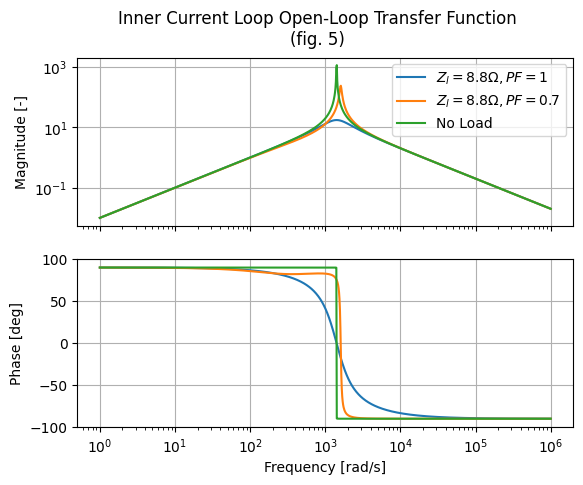

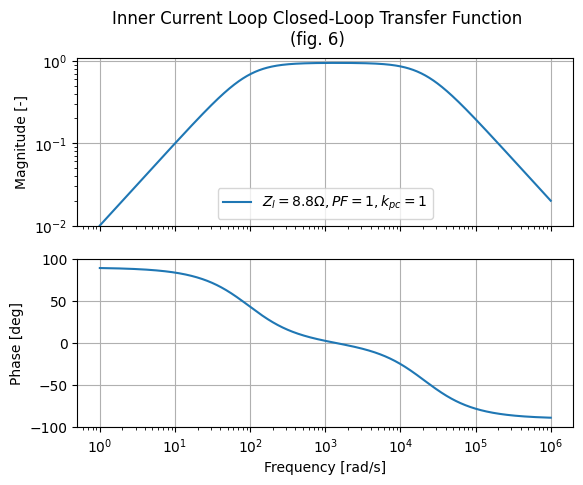

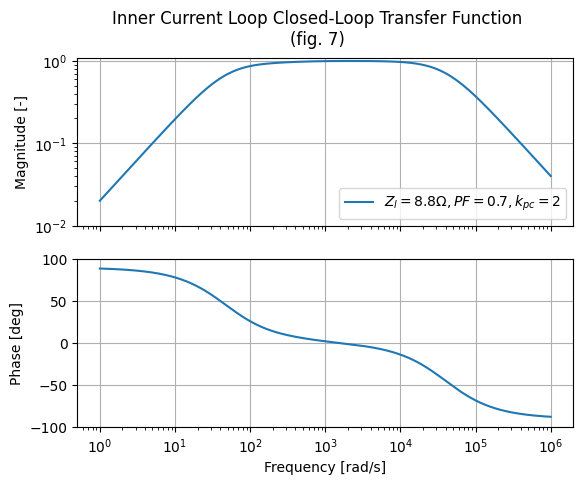

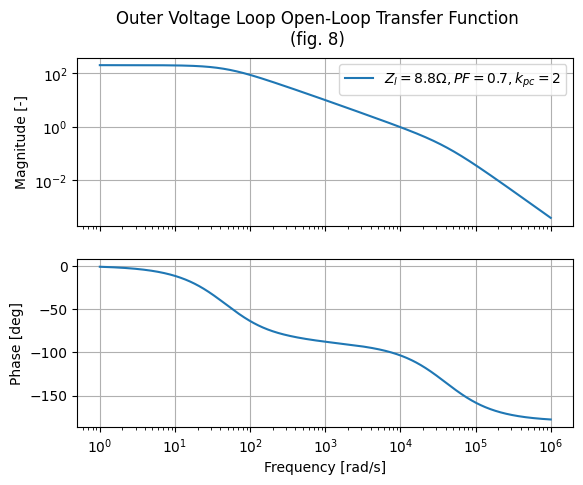

In [10]:
# Define constants
s = ctr.tf([1, 0], 1)

ref_w = 60*2*np.pi

Lf = 5e-3
Cf = 100e-6

Vi = 100

# Define the transfer functions
def get_gic(Vi, Lf, Cf, Rl, Ll):
    Gic = Vi/Lf * s * (Ll*s + Rl) / (Ll*s**3 + Rl*s**2 + 1/Cf*(1 + Ll/Lf)*s + Rl/(Lf*Cf))
    return Gic

# Full load unity PF
Zl = 8.8
PF = 1
theta = np.arccos(PF)
Rl = Zl * np.cos(theta)
Ll = Zl * np.sin(theta) / ref_w

Gic_pf1 = get_gic(Vi, Lf, Cf, Rl, Ll)

# Full load 0.7 PF
Zl = 8.8
PF = 0.7
theta = np.arccos(PF)
Rl = Zl * np.cos(theta)
Ll = Zl * np.sin(theta) / ref_w

Gic_pf0_7 = get_gic(Vi, Lf, Cf, Rl, Ll)

# No load
Zl = 1e5
PF = 1
theta = np.arccos(PF)
Rl = Zl * np.cos(theta)
Ll = Zl * np.sin(theta) / ref_w

Gic_noload = get_gic(Vi, Lf, Cf, Rl, Ll)

# Define frequency vectors
omegavec = np.logspace(0, 6, 1000)
fvec = omegavec / (2*np.pi)

# Plot Figure 5
fig, ax = plt.subplots(2, 1, sharex=True)
m_1, p_1, w = ctr.freqresp(Gic_pf1, omegavec)
m_0_7, p_0_7, w = ctr.freqresp(Gic_pf0_7, omegavec)
m_nl, p_nl, w = ctr.freqresp(Gic_noload, omegavec)

ax[0].loglog(omegavec, m_1, label='$Z_l = 8.8 \Omega, PF=1$')
ax[0].loglog(omegavec, m_0_7, label='$Z_l = 8.8 \Omega, PF=0.7$')
ax[0].semilogx(omegavec, m_nl, label='No Load')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_ylabel('Magnitude [-]')


ax[1].semilogx(omegavec, np.unwrap(p_1)*180/np.pi)
ax[1].semilogx(omegavec, np.unwrap(p_0_7)*180/np.pi)
ax[1].semilogx(omegavec, np.unwrap(p_nl)*180/np.pi)
ax[1].grid('enable')

ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [rad/s]')
ax[1].set_ylim([-100, 100])

fig.suptitle('Inner Current Loop Open-Loop Transfer Function\n(fig. 5)')
# fig.savefig('figs/fig5.eps', format='eps')


# Define TF for Figure 6
k_pc1 = 1
Li_pf1 = k_pc1 * Gic_pf1
Gic_pf1_cl = Li_pf1 / (1+Li_pf1)
m_1_cl, p_1_cl, w = ctr.freqresp(Gic_pf1_cl, omegavec)

# Plot Fig 6
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].loglog(omegavec, m_1_cl, label='$Z_l = 8.8 \Omega, PF=1, k_{pc}=1$')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_ylabel('Magnitude [-]')
ax[0].set_ylim([1e-2, 1.1])

ax[1].semilogx(omegavec, np.unwrap(p_1_cl)*180/np.pi)
ax[1].grid('enable')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [rad/s]')
ax[1].set_ylim([-100, 100])

fig.suptitle('Inner Current Loop Closed-Loop Transfer Function\n(fig. 6)')
# fig.savefig('figs/fig6.eps', format='eps')


# Define TF for Figure 7
k_pc2 = 2
Li_pf0_7 = k_pc2 * Gic_pf0_7
Gic_pf0_7_cl =  Li_pf0_7 / (1+Li_pf0_7)
m_0_7_cl, p_0_7_cl, w = ctr.freqresp(Gic_pf0_7_cl, omegavec)

# Plot Fig 7
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].loglog(omegavec, m_0_7_cl, label='$Z_l = 8.8 \Omega, PF=0.7, k_{pc}=2$')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_ylabel('Magnitude [-]')
ax[0].set_ylim([1e-2, 1.1])

ax[1].semilogx(omegavec, np.unwrap(p_0_7_cl)*180/np.pi)
ax[1].grid('enable')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [rad/s]')
ax[1].set_ylim([-100, 100])

fig.suptitle('Inner Current Loop Closed-Loop Transfer Function\n(fig. 7)')
# fig.savefig('figs/fig7.eps', format='eps')


# Define TF for Figure 8
k_pc = 2
Li = k_pc * Gic_pf1
Gic_pf0_7_cl = Li_pf0_7 / (1+Li_pf0_7)
Gvc = 1/(s*Cf) * Gic_pf0_7_cl
mv, pv, w = ctr.freqresp(Gvc, omegavec)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].loglog(omegavec, mv, label='$Z_l = 8.8 \Omega, PF=0.7, k_{pc}=2$')
ax[0].grid('enable')
ax[0].legend()
ax[0].set_ylabel('Magnitude [-]')

ax[1].semilogx(omegavec, np.unwrap(pv)*180/np.pi)
ax[1].grid('enable')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [rad/s]')

fig.suptitle('Outer Voltage Loop Open-Loop Transfer Function\n(fig. 8)')
# fig.savefig('figs/fig8.eps', format='eps')
